In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statistics

In [5]:
df=pd.read_csv('../data/CleanedAirQuality.csv')

# Visualization of all pollutants

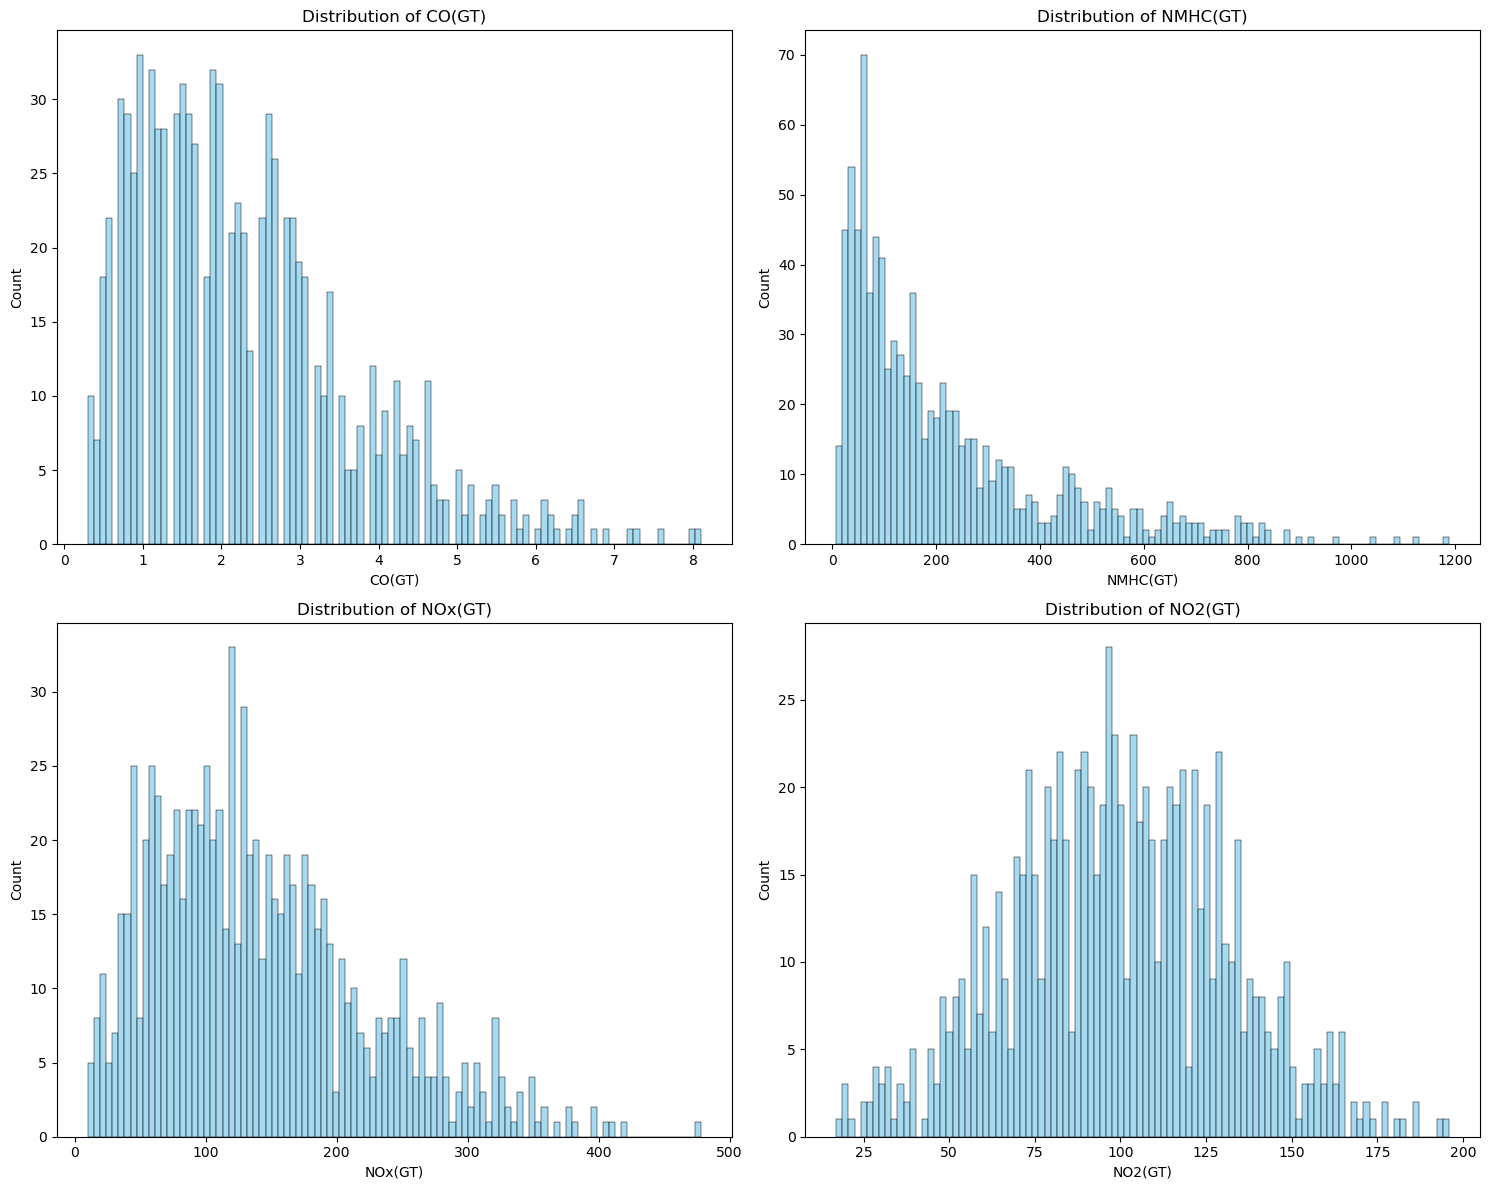

In [90]:
columns = ['CO(GT)', 'NMHC(GT)', 'NOx(GT)', 'NO2(GT)']

# Create a 2x2 matrix of subplots
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
axes = axes.flatten()  # Flatten the axes array for easier indexing

# Loop through columns and axes
for i, col in enumerate(columns):
    # Filter the data
    filtered_df = df[df[col] > -200]
    
    # Create histogram
    sns.histplot(filtered_df[col], color='skyblue', edgecolor='black', bins=100, ax=axes[i])
    
    # Set titles and labels
    axes[i].set_title(f'Distribution of {col}')
    axes[i].set_xlabel(col)
    axes[i].set_ylabel('Count')

# Adjust layout to avoid overlap
plt.tight_layout()
plt.show()

# Time-Series Trends of Major Pollutants

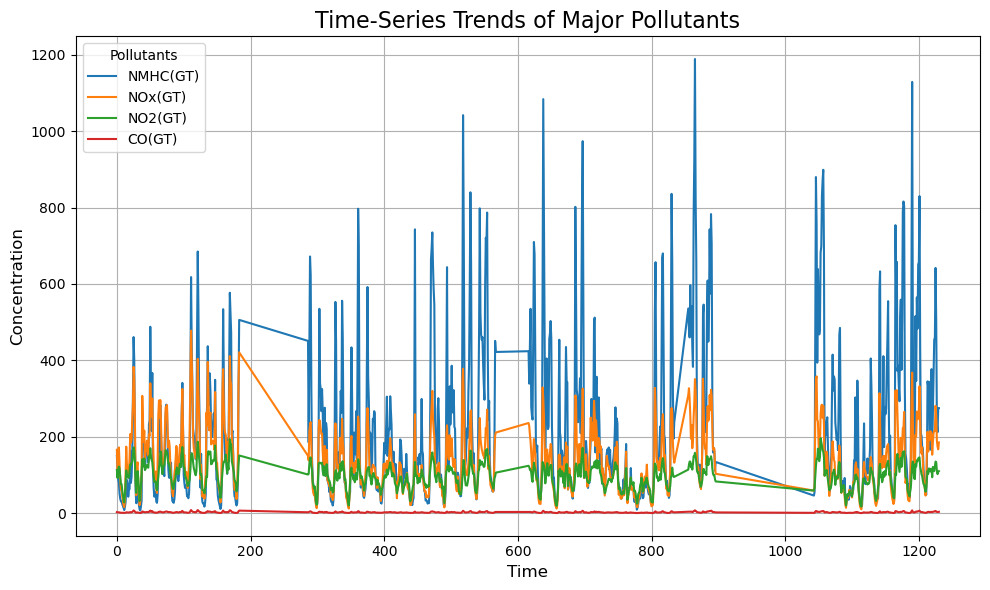

In [92]:
# List of major pollutants to plot
pollutants = [ 'NMHC(GT)', 'NOx(GT)', 'NO2(GT)','CO(GT)']
plt.figure(figsize=(10,6))

for pollutant in pollutants:
    filtered_df = df[df[pollutant] > -200]
    plt.plot(filtered_df.index, filtered_df[pollutant], label=pollutant)

plt.title('Time-Series Trends of Major Pollutants', fontsize=16)
plt.xlabel('Time', fontsize=12)
plt.ylabel('Concentration', fontsize=12)
plt.legend(title='Pollutants', fontsize=10)
plt.grid()
plt.tight_layout()
plt.show()

# Correlation between all polutants

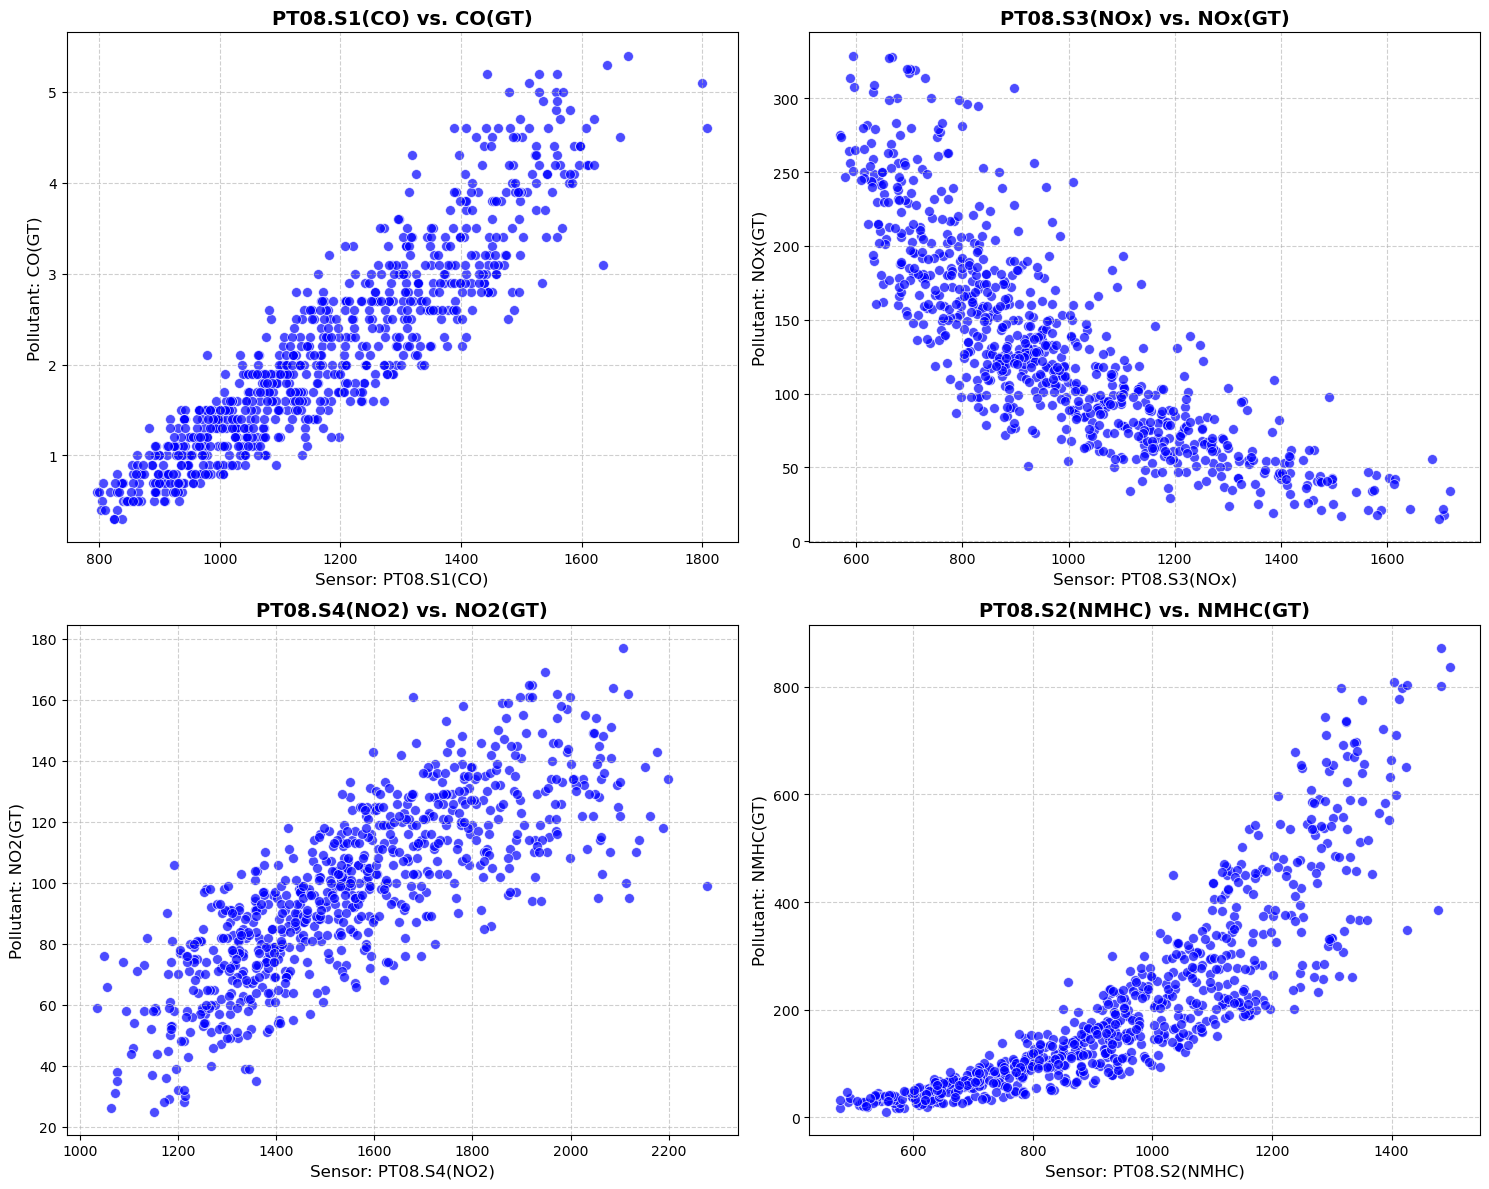

In [94]:
# removing values equaling to -200 in 'NMHC(GT)' column, that might with identifying outliers
df = df[df['NMHC(GT)']>-200]

# Creating a function for identifying outliers and removing the said outliers
def outliers(data,cols):
    for col in cols:
        q1 = np.quantile(data[col],0.25)
        q3 = np.quantile(data[col],0.75)
        iqr = q3-q1
        lb = q1 - 1.5*iqr
        ub = q3 + 1.5*iqr
        data = data[(data[col]>=lb)&(data[col]<=ub)]
    return data

# Creating a list of columns for checking outliers
cols_outl = ['PT08.S1(CO)', 'PT08.S3(NOx)',  'PT08.S4(NO2)', 'PT08.S5(O3)', 'PT08.S2(NMHC)',
             'CO(GT)', 'NOx(GT)', 'NO2(GT)', 'C6H6(GT)']
df_out = outliers(df,cols_outl)

# Creating list of column names corresponding to their categories for later use.
sensor_cols = ['PT08.S1(CO)', 'PT08.S3(NOx)',  'PT08.S4(NO2)', 'PT08.S2(NMHC)']
pollutant_cols = ['CO(GT)', 'NOx(GT)', 'NO2(GT)', 'NMHC(GT)']
weather_cols = ['T', 'RH', 'AH']

# Creating a dictionary of sensors as keys and values as their pollutant
# This can be used to create scatter plots
sen_poll = {sensor_cols[x]:pollutant_cols[x] for x in range(len(sensor_cols))}

# Creating a 2x2 matrix of subplots
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
axes = axes.flatten()

# Iterate through the sensor-pollutant dictionary and corresponding axes
for i, (sensor, pollutant) in enumerate(sen_poll.items()):
    sns.scatterplot(
        x=df_out[sensor],
        y=df_out[pollutant],
        alpha=0.7,
        s=50,
        color='blue',
        ax=axes[i]
    )
    axes[i].set_title(f'{sensor} vs. {pollutant}', fontsize=14, fontweight='bold')
    axes[i].set_xlabel(f'Sensor: {sensor}', fontsize=12)
    axes[i].set_ylabel(f'Pollutant: {pollutant}', fontsize=12)
    axes[i].grid(linestyle='--', alpha=0.6)

# Adjust layout
plt.tight_layout()
plt.show()

# Correlation between **Pollutants VS Climate** & **Pollutants VS Sensors**

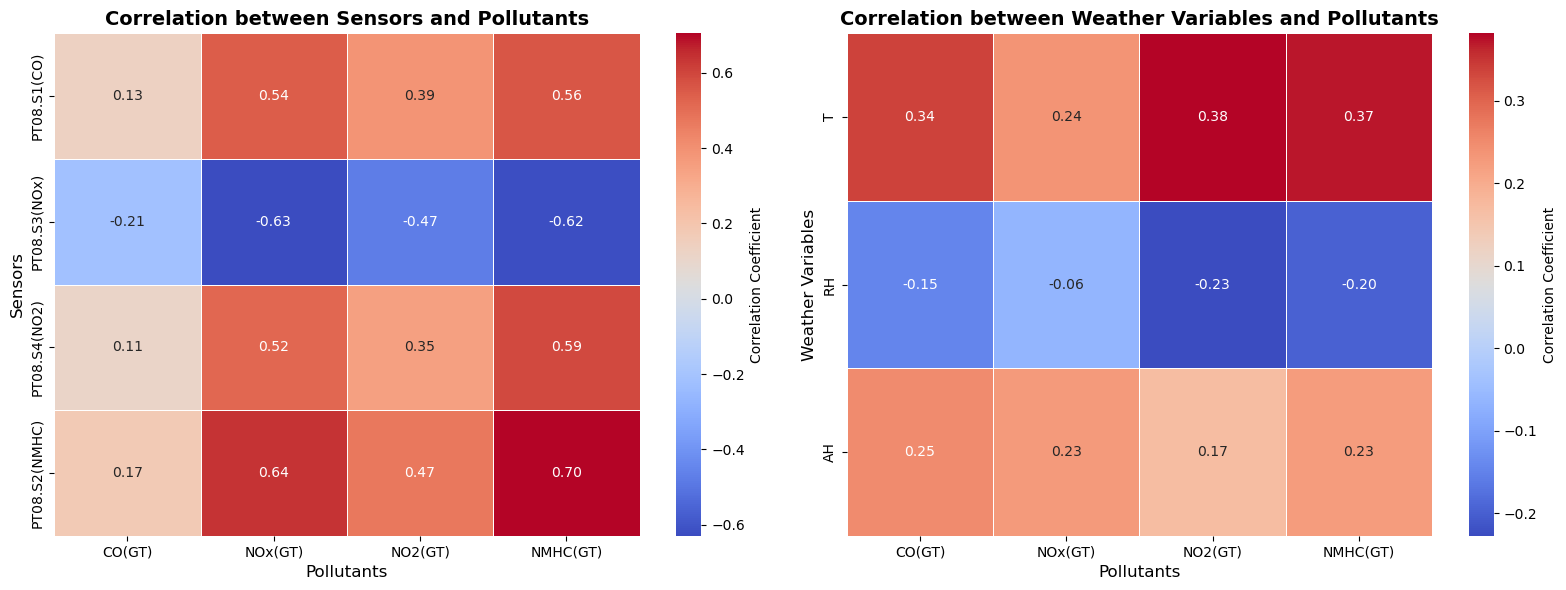

In [56]:
correlation = df[sensor_cols+pollutant_cols+weather_cols].corr()
sensor_pollutant_corr = correlation.loc[sensor_cols, pollutant_cols]

weather_pollut = df_out[pollutant_cols+weather_cols]
weather_pollut_corr = weather_pollut.corr()

# Set up the figure with 1 row and 2 columns for side-by-side heatmaps
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Heatmap 1: Correlation between Sensors and Pollutants
sns.heatmap(sensor_pollutant_corr,
            cmap='coolwarm',
            annot=True,
            fmt=".2f",
            linewidths=0.5,
            cbar_kws={'label': 'Correlation Coefficient'},
            ax=axes[0])
axes[0].set_title('Correlation between Sensors and Pollutants', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Pollutants', fontsize=12)
axes[0].set_ylabel('Sensors', fontsize=12)

# Heatmap 2: Correlation between Weather Variables and Pollutants
sns.heatmap(weather_pollut_corr.loc[weather_cols, pollutant_cols],
            cmap='coolwarm',
            annot=True,
            fmt=".2f",
            linewidths=0.5,
            cbar_kws={'label': 'Correlation Coefficient'},
            ax=axes[1])
axes[1].set_title('Correlation between Weather Variables and Pollutants', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Pollutants', fontsize=12)
axes[1].set_ylabel('Weather Variables', fontsize=12)

# Adjust layout
plt.tight_layout()
plt.show()

# **Hourly , Daily & Monthly Trends** of Peak Pollution Periods

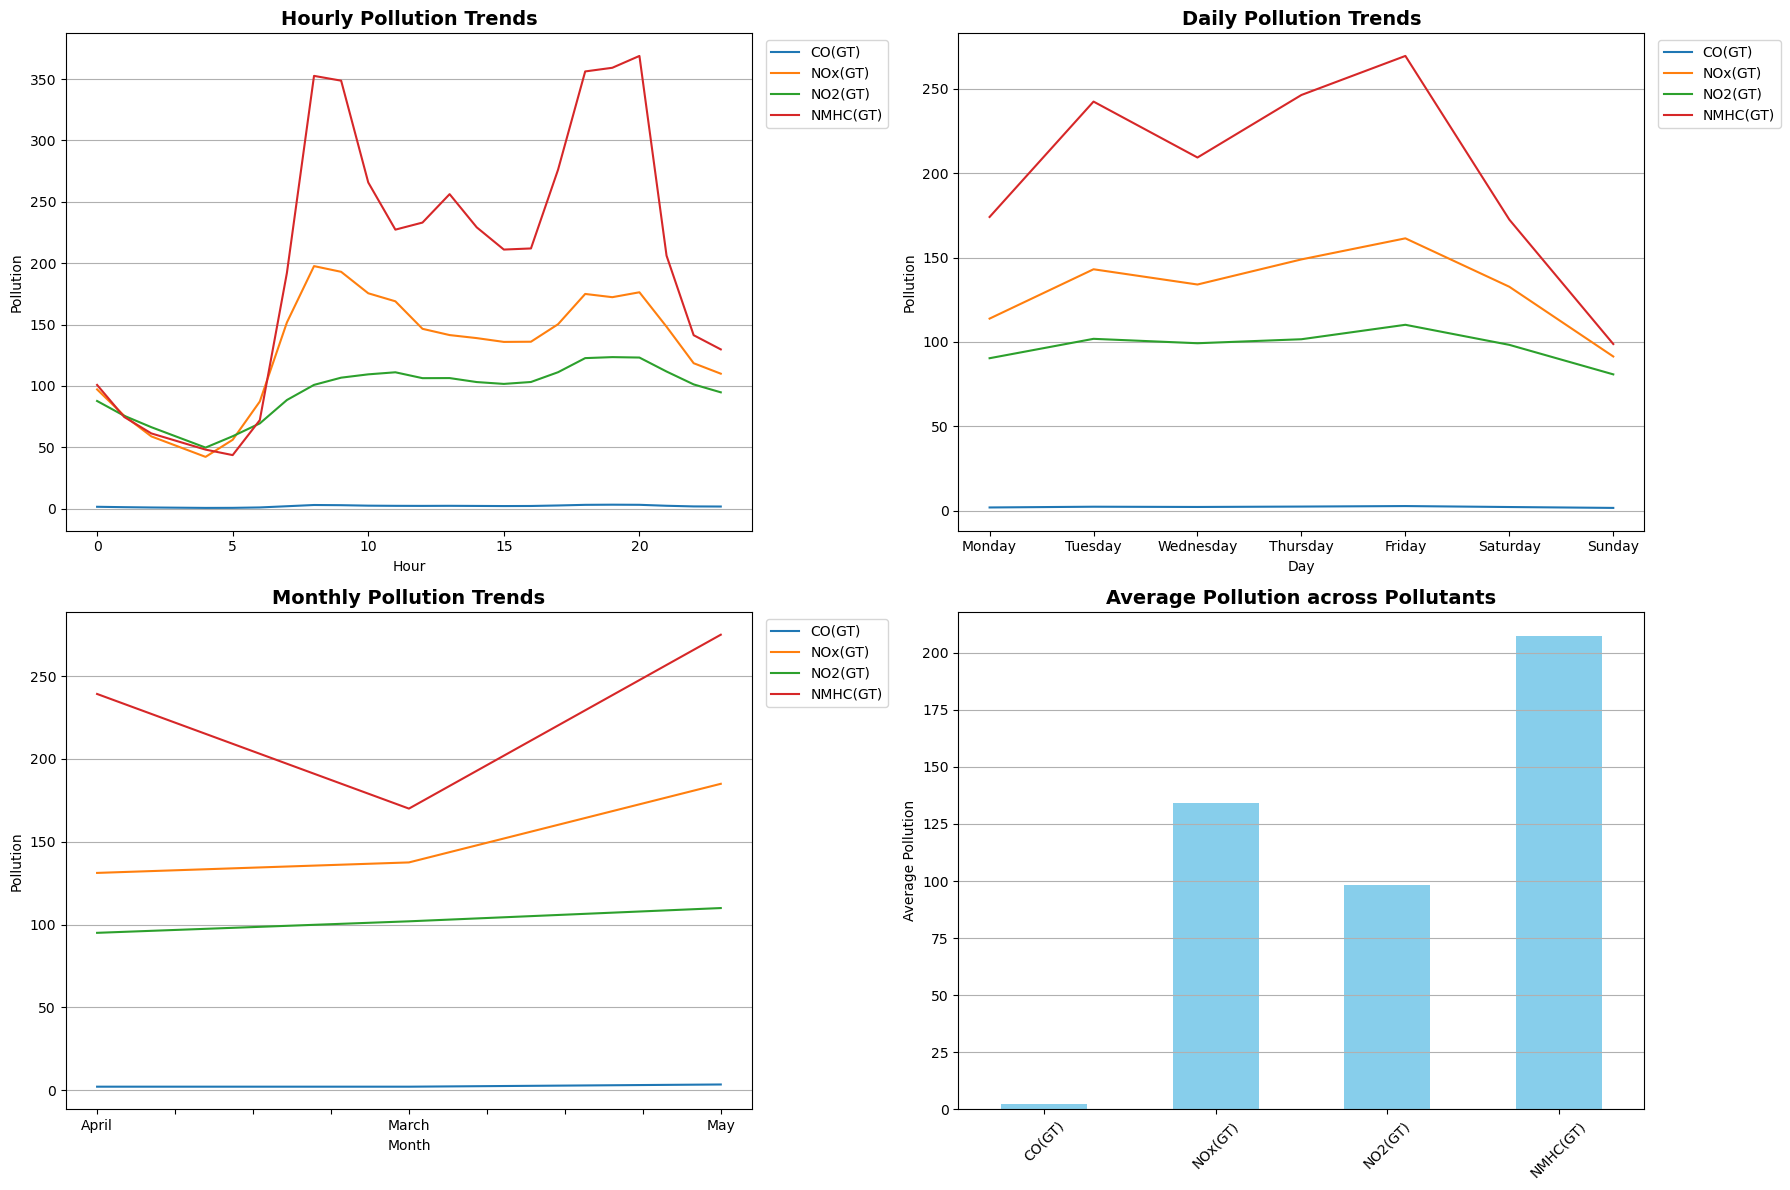

In [69]:
df_out['Date'] = pd.to_datetime(df_out['Date'], errors='coerce')

# Check for any rows with invalid dates and drop them
df_out = df_out.dropna(subset=['Date'])

# Extract Day and Month names
df_out['Day'] = df_out['Date'].dt.day_name()
df_out['Month'] = df_out['Date'].dt.month_name()
# Adding Hour column
df_out['Time'] = pd.to_datetime(df_out['Time'], format='%H:%M:%S', errors='coerce').dt.time
df_out['Hour'] = df_out['Time'].apply(lambda x: x.hour)

# Adding Day column
df_out['Day'] = df_out['Date'].dt.day_name()

# Adding Month column
df_out['Month'] = df_out['Date'].dt.month_name()

# Columns of interest
pollutant_cols = ['CO(GT)', 'NOx(GT)', 'NO2(GT)', 'NMHC(GT)']

# Prepare data for the fourth plot: Average pollution across all pollutants
avg_pollution = df_out[pollutant_cols].mean()

# Create a 2x2 matrix of plots
fig, axes = plt.subplots(2, 2, figsize=(18, 12))

# Plot 1: Hourly Pollution Trends
df_out.groupby('Hour')[pollutant_cols].mean().plot(kind='line', ax=axes[0, 0])
axes[0, 0].set_title('Hourly Pollution Trends', fontsize=14, fontweight='bold')
axes[0, 0].set_ylabel('Pollution')
axes[0, 0].legend(bbox_to_anchor=(1.01, 1), loc='upper left')
axes[0, 0].grid(axis='y')

# Plot 2: Daily Pollution Trends
daily_trends = df_out.groupby('Day')[pollutant_cols].mean()
daily_trends = daily_trends.reindex(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
daily_trends.plot(kind='line', ax=axes[0, 1])
axes[0, 1].set_title('Daily Pollution Trends', fontsize=14, fontweight='bold')
axes[0, 1].set_ylabel('Pollution')
axes[0, 1].legend(bbox_to_anchor=(1.01, 1), loc='upper left')
axes[0, 1].grid(axis='y')

# Plot 3: Monthly Pollution Trends
df_out.groupby('Month')[pollutant_cols].mean().plot(kind='line', ax=axes[1, 0])
axes[1, 0].set_title('Monthly Pollution Trends', fontsize=14, fontweight='bold')
axes[1, 0].set_ylabel('Pollution')
axes[1, 0].legend(bbox_to_anchor=(1.01, 1), loc='upper left')
axes[1, 0].grid(axis='y')

# Plot 4: Average Pollution across Pollutants
avg_pollution.plot(kind='bar', color='skyblue', ax=axes[1, 1])
axes[1, 1].set_title('Average Pollution across Pollutants', fontsize=14, fontweight='bold')
axes[1, 1].set_ylabel('Average Pollution')
axes[1, 1].set_xticklabels(avg_pollution.index, rotation=45)
axes[1, 1].grid(axis='y')

plt.tight_layout()
plt.show()